### Validando a detecção de anomalias para a feature "Total de valor comprovado"

### Features Extracted:

- https://github.com/lappis-unb/salic-ml/wiki/Brainstorming-de-features-para-estimar-Complexidade-Financeira
    
Gerar features de um segmento "ESPECÍFICO" e "GLOBAIS".

#### Recarregar automaticamente os módulos

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importing data

In [16]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


from salicml.utils.dates import Dates
from salicml.utils.read_csv import read_csv
from salicml.utils.utils import debug

PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')

#### PLANILHA ORCAMENTARIA

QUERY: /data/scripts/planilha_orcamentaria.sql


In [17]:
dt_comprovacao_name = 'planilha_comprovacao_2.csv'
usecols = ['idPlanilhaAprovacao', 'PRONAC', 'vlComprovacao', 'idSegmento']

dt_items = read_csv(dt_comprovacao_name, usecols=usecols)
display(dt_items.columns)
dt_items.head()

Index(['PRONAC', 'idPlanilhaAprovacao', 'idSegmento', 'vlComprovacao'], dtype='object')

,PRONAC,idPlanilhaAprovacao,idSegmento,vlComprovacao
0,1012121,18552,71,12000.0
1,1012121,18553,71,6000.0
2,1012121,18554,71,12000.0
3,1012121,18555,71,6000.0
4,1012121,18556,71,8000.0


### FEATURES 
    - Valor total comprovado por projeto

# Dividindo pronacs de treino e pronacs de teste

50/50

In [18]:
from sklearn.model_selection import train_test_split


all_pronacs = dt_items.PRONAC.unique()
pronacs_train, pronacs_test = train_test_split(all_pronacs, test_size=0.5)


dt_train = dt_items[dt_items['PRONAC'].isin(pronacs_train)]
dt_test = dt_items[dt_items['PRONAC'].isin(pronacs_test)]

In [19]:
print('pronacs_train = {}'.format(pronacs_train))
print('pronacs_test = {}'.format(pronacs_test))

assert (dt_train.shape[0] + dt_test.shape[0]) == dt_items.shape[0]

display(dt_train.head())
display(dt_test.head())

pronacs_train = [ 173436  163272  159960 ... 1011786  148413  120872]
pronacs_test = [ 158019  162231  160518 ... 1412036  152369  111947]


,PRONAC,idPlanilhaAprovacao,idSegmento,vlComprovacao
0,1012121,18552,71,12000.0
1,1012121,18553,71,6000.0
2,1012121,18554,71,12000.0
3,1012121,18555,71,6000.0
4,1012121,18556,71,8000.0


,PRONAC,idPlanilhaAprovacao,idSegmento,vlComprovacao
146,110741,19499,26,100.0
147,110741,19499,26,200.0
148,110741,19499,26,2000.0
149,110741,19499,26,1000.0
150,110741,19499,26,2000.0


In [20]:
segment_projects = dt_train[['PRONAC', 'idSegmento', 'vlComprovacao']].groupby(['idSegmento', 'PRONAC']).sum()
segment_projects.head()

vlComprovacao
idSegmento PRONAC               
11         120629       73446.27
           121257       12795.00
           123330      230664.87
           123402       67817.54
           124545      178427.50

### Plotando as distribuiçoes dos segmentos mais comuns

In [21]:
common_segements = segment_projects.groupby(['idSegmento']).count().sort_values(by='vlComprovacao', ascending=False)
common_segements.rename(columns={'vlComprovacao': 'Número de projetos'}, inplace=True)
display(common_segements.head())

,Número de projetos
idSegmento,
11,345
33,208
12,124
32,114
4B,110


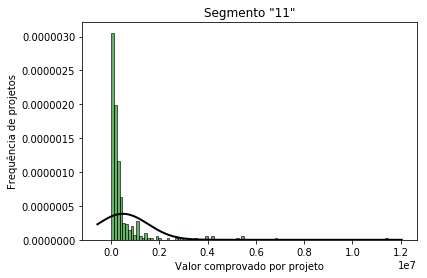

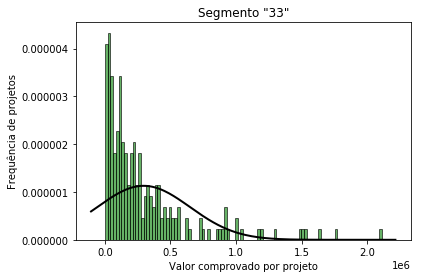

In [ ]:
from scipy.stats import norm


def plot_segment(id, funds):
    plt.hist(funds, bins=100, density=True, alpha=0.6, color='g', edgecolor='black')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.title('Segmento "{}"'.format(id))
    plt.xlabel('Valor comprovado por projeto')
    plt.ylabel('Frequência de projetos')

    mu, std = np.mean(funds), np.std(funds)
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 200)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.show()

for counter, id_segmento in enumerate(common_segements.index.values):    
    projects_verified_funds = segment_projects.loc[id_segmento].vlComprovacao.values
    plot_segment(id_segmento, projects_verified_funds)
    
    counter += 1
    if counter == 10:
        break

In [ ]:
segment_funds_avg_std = segment_projects.groupby(['idSegmento'])
segment_funds_avg_std = segment_funds_avg_std.agg(['count', 'sum', 'mean', 'std'])

segment_funds_avg_std.columns = segment_funds_avg_std.columns.droplevel(0)

display(segment_funds_avg_std)

# Calculando a porcentagem de outliers no conjunto de teste

In [ ]:
project_funds_grp = dt_items.drop(columns=['idPlanilhaAprovacao']).groupby(['PRONAC'])
project_funds = project_funds_grp.sum()
project_funds.head()

In [ ]:
id_segmento = '11'
display(segment_funds_avg_std.loc[id_segmento])
mean = segment_funds_avg_std.loc[id_segmento]['mean']

In [ ]:
from salicml.outliers.gaussian_outlier import is_outlier


def is_total_verified_funds_outlier(pronac):
    assert isinstance(pronac, int)
    
    verified_funds = project_funds.loc[pronac]['vlComprovacao']
    id_segmento = project_funds_grp.get_group(pronac).iloc[0]['idSegmento']
    
    if not np.isin(id_segmento, segment_funds_avg_std.index):
        raise ValueError('Segment {} was not trained'.format(id_segmento))
    
    mean = segment_funds_avg_std.loc[id_segmento]['mean']
    std = segment_funds_avg_std.loc[id_segmento]['std']
    outlier = is_outlier(verified_funds, mean, std)
    return outlier

pronac = int(np.random.choice(dt_test.PRONAC.values))
print('pronac = {}'.format(pronac))
is_total_verified_funds_outlier(pronac)

In [ ]:
from salicml.outliers.gaussian_outlier import outlier_probability


print(1 - outlier_probability(0.0, 1.0, c=1.5))

In [ ]:
pronacs_test = dt_test.PRONAC.unique()

outlier_arr = []

for i, pronac in enumerate(pronacs_test):
    try:
        outlier = is_total_verified_funds_outlier(int(pronac))
        outlier_arr.append(1.0 if outlier else 0.0)
    except ValueError as err:
        print(err)
    
describe = pd.DataFrame(outlier_arr).describe()
display(describe)

# Análise dos resultados

Para `c = 1.5`, esperava-se que `6.68%` dos projetos fossem considerados outliers em termos dos números de itens por projeto. Entretanto, para os conjuntos de treino e teste utilizados e `c = 1.5`, `7.57%`dos projetos foram considerados outliers.

# Contribuições futuras

A celula anterior demonstra um problema na divisão dos pronacs nos conjuntos de treino e teste: alguns segmentos, por exemplo o segmento `9I` ficaram fora do conjunto do treino, o que não permite detectar anomalias para este segmento e os demais que não foram incluidos no conjunto de treino. Portanto uma contribução futura desejável é que o conjunto de treino garanta que para segmento, pelo menos 50% do total dos projetos para aquele segmento esteja dentro do conjunto de pronacs de treino.